# Initialize

## Setup packages

In [1]:
!pip install netCDF4
!pip install basemap
!pip install torch
!pip install captum

In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
from pylab import meshgrid, colorbar
import torch
from sklearn.metrics import r2_score
from captum.attr import (
    IntegratedGradients, Saliency, NoiseTunnel,
    InputXGradient, LRP, Lime, KerneShap
)

## Settings

In [3]:
# Random seed
seed = 123
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

# Prepare SST anomaly dataset

## Download SST data

This demo uses data from the [COBE SST2 and Sea-Ice](https://psl.noaa.gov/data/gridded/data.cobe2.html) dataset.

    Hirahara, S., Ishii, M., and Y. Fukuda, 2014: Centennial-scale sea surface 
    temperature analysis and its uncertainty. J of Climate, 27, 57-75. 
    http://journals.ametsoc.org/doi/pdf/10.1175/JCLI-D-12-00837.1 . 

In [4]:
# Monthly mean surface SST
url_monthly = "https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.mean.nc"
# Climatology monthly surface SST
url_climate = "https://psl.noaa.gov/thredds/dodsC/Datasets/COBE2/sst.mon.ltm.1981-2010.nc"

# Open NetCDF datasets
ds_sst_monthly = nc.Dataset(url_monthly)
ds_sst_climate = nc.Dataset(url_climate)

# Extract gridded data's latitude & longitude
lat = ds_sst_monthly["lat"][:]
print("Lat shape: ", lat.shape)
lon = ds_sst_monthly["lon"][:]
print("Lon shape: ", lon.shape)

# Extracted gridded monthly mean surface SST array, in parts because of size
sst_m_1 = np.array(ds_sst_monthly["sst"][:1020])   # Part 1
sst_m_2 = np.array(ds_sst_monthly["sst"][1020:])   # Part 2
sst_m = np.concatenate((sst_m_1, sst_m_2))         # Concatenate
print("SST shape: ", sst_m.shape)

# Extract gridded monthly climatology
sst_c = np.array(ds_sst_climate["sst"])
print("SST climatology shape", sst_c.shape)

# Convert months since 0 to between (1-12)
# That is, n2month(13) is month 1
def n2month(n):
    m = n % 12
    if m == 0:
        m = 12
    return m

Lat shape:  (180,)
Lon shape:  (360,)
SST shape:  (2040, 180, 360)
SST climatology shape (12, 180, 360)


## Calculate SST anomaly

In [5]:
# Tile the climatology for vectorized calculation of SST anomaly
monthsInYear = 12
nYears = sst_m.shape[0] / monthsInYear
sst_c_tiled = np.tile(sst_c, (int(nYears), 1,1))

# Ensure correct shapes
if (sst_c_tiled.shape != sst_m.shape):
    print("ERROR: Mismatch shape between operands!")
    raise

# Replace numeric invalid data flags with NAN
sst_m_ = np.copy(sst_m)
sst_m_ = np.where(np.greater(sst_m_, 1000), np.nan, sst_m_)
sst_c_tiled = np.copy(sst_c_tiled)
sst_c_tiled = np.where(np.less(sst_c_tiled, -1000), np.nan, sst_c_tiled)

# Calculate SST anomaly
sst_a = sst_m_ - sst_c_tiled

# Print value ranges to make sure they look reasonable
print("SST M:", np.nanmin(sst_m_), np.nanmax(sst_m_))
print("SST C:", np.nanmin(sst_c_tiled), np.nanmax(sst_c_tiled))
print("SST A:", np.nanmin(sst_a), np.nanmax(sst_a))

SST M: -3.0000002 34.378002
SST C: -1.9064999 33.221
SST A: -10.187901 6.092101


## Downsample SST anomaly

In [6]:
# Downsample

def bin_ndarray(ndarray, new_shape, operation='sum'):
    """
    Source: https://stackoverflow.com/a/29042041
    
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.

    Number of output dimensions must match number of input dimensions and 
        new axes must divide old ones.

    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)

    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]

    """
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

sst_a_small = np.array([bin_ndarray(arr, (18, 36), operation = "mean") for arr in sst_a])

## Plot SST data

Source: https://polar.ncep.noaa.gov/global/examples/usingpython.shtml 

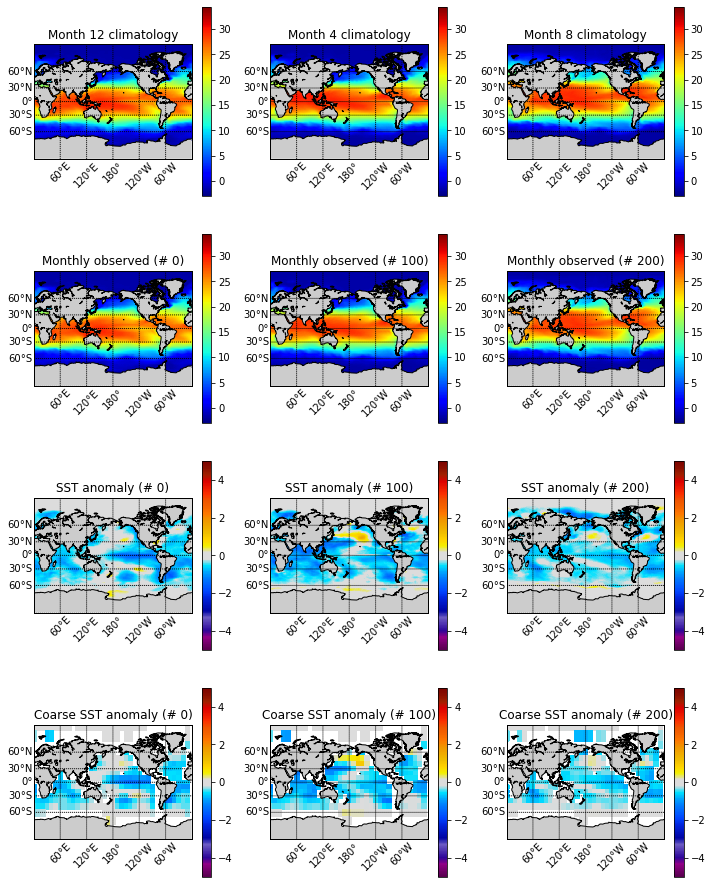

In [7]:
# Color pallete for SST anomaly
colors = ["#57004d", "#730069", "#910087", "#2c0699", "#4d32af", "#6b5ac3", "#0004a4", "#0014c0", "#0024dc", "#0043ff", "#005fff", "#007bff", "#00a5ff", "#00e1ff", "#dcdcdc", "#dcdcdc", "#f3f000", "#ffd200", "#f0be00", "#f0aa00", "#f09600", "#fd7800", "#f56400", "#ef5500", "#fb3000", "#eb1800", "#db0000", "#a02000", "#8a0f00", "#7d0400"]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
cmap.set_over('#3c0000')
cmap.set_under('#28000a')

# Examples to plot
example_idxs = [0, 100, 200]
nExamples = len(example_idxs)

fig, axs = plt.subplots(4, 3, figsize=(12,16))
for i, e in enumerate(example_idxs):
    
    # Climatology
    vmin = min(np.nanmin(sst_m_), np.nanmin(sst_c_tiled))
    vmax = max(np.nanmax(sst_m_), np.nanmax(sst_c_tiled))
    data = sst_c_tiled[e]
    axs[0][i].title.set_text("Month {} climatology".format(n2month(e)))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[0][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap="jet")
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[0][i])
    
    # Observed 
    vmin = min(np.nanmin(sst_m_), np.nanmin(sst_c_tiled))
    vmax = max(np.nanmax(sst_m_), np.nanmax(sst_c_tiled))
    data = sst_m_[e]
    axs[1][i].title.set_text("Monthly observed (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[1][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap="jet")
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[1][i])
    
    # Anomaly
    vmin = -5
    vmax = 5
    data = sst_a[(e)]
    axs[2][i].title.set_text("SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[2][i])
    Lon, Lat = meshgrid(lon,lat)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[2][i]) 
    
    # Downsampled anomaly
    vmin = -5
    vmax = 5
    data = sst_a_small[(e)]
    axs[3][i].title.set_text("Coarse SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[3][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[3][i])     

# Create synthetic dataset

## Calculate correlation matrix from observation samples

In [8]:
# Reshape s.t. each 2D SST field is flattened 
sst = np.copy(sst_a_small)
sst_shape = sst.shape
print("Original shape: ", sst_shape)
sst_r = sst.reshape(sst_shape[0], sst_shape[1] * sst_shape[2])
print("New shape: ", sst_r.shape)

# Calculate correlation coef
sst_r_t = np.transpose(sst_r)
sst_cov = np.cov(sst_r_t)
sst_cov = np.nan_to_num(sst_cov, nan=0.0)

Original shape:  (2040, 18, 36)
New shape:  (2040, 648)


## Generate synthetic samples

In [9]:
nSamples = int(10e3)
samples_flat = rng.multivariate_normal(np.zeros(sst_cov.shape[0]), sst_cov, size = nSamples)
# Convert to 2D grid for plotting
samples_grid = samples_flat.reshape(nSamples, sst_shape[1], sst_shape[2])

# Define synthetic response function

In [10]:
# Samples
X = samples_flat
# Number of samples
N = X.shape[1]

## Generate piecewise linear functions

In [11]:
# Number of segments of the piecewise functions
K = 5

# Generate piecewise coeffs
B = np.transpose(rng.multivariate_normal(np.zeros(sst_cov.shape[0]), sst_cov, size = K-1))
# B = np.random.rand(N, K - 1)
print(B.shape)

# Generate bounds
x_min = np.nanmin(X)
x_max = np.nanmax(X)
boundaries = np.linspace(x_min, x_max, K)
print(boundaries)

# Generate conditions
nFunc = len(boundaries) - 1
C = np.zeros((nFunc, X.shape[0], X.shape[1]))
for i in range(nFunc):
    C[i] = np.logical_and(X > boundaries[i],  X <= boundaries[i + 1])
    
# Linear function
def f(x, b):
    return x * b

# Piecewise linear function
def pf_cell(X, C, B):
    return np.piecewise(X, C, [lambda x=x, b=b: f(x, b) for b in B])
                            
# Piecewise linear function at each cell
def pf_cells(X, C, B):
    return np.transpose(np.array([pf_cell(X[:,i], C[:,:,i], B[i]) for i in range(X.shape[1])]))

(648, 4)
[-3.00991143 -1.45872549  0.09246044  1.64364638  3.19483232]


## Combine to form additive separable function 

In [12]:
# Linearly separable sum of cell-wise piecewise functions
def F(X, C, B):
    return np.sum(pf_cells(X, C, B), axis=1)

## Demonstrate functions

In [13]:
# Test the functions
print("Samples (X) shape: ", X.shape)
print("Conditions (C) shape: ", C.shape)
print("Piecewise coeffs (B) shape: ", B.shape)
print("")

print("Single evaluation of a linear function:")
x = X[0,0]  #(sample, cell)
b = B[0,2]  #(cell, piece)
y = f(x, b)
print("f({}, {}) = {}".format(x, b, y))
print("")

print("Evaluate piecewise linear function at a single cell:")
x = X[0,0]
c = C[:,0,0]
b = B[0,:]
print("x = {}".format(x))
print("boundaries = {}".format(boundaries))
print("c = {}".format(c))
print("b = {}".format(b))
y = pf_cell(x, c, b)
print("y = {}".format(y))
print("")

print("Evaluate piecewise linear function at all cells:")
attribution = pf_cells(X, C, B)
print("Output shape: ", attribution.shape)
print("")

print("Evaluate F(sample):")
y_values = F(X, C, B)
print("Output shape:", y.shape)

Samples (X) shape:  (10000, 648)
Conditions (C) shape:  (4, 10000, 648)
Piecewise coeffs (B) shape:  (648, 4)

Single evaluation of a linear function:
f(0.14158203001646869, -0.17449285633961917) = -0.024705052823935317

Evaluate piecewise linear function at a single cell:
x = 0.14158203001646869
boundaries = [-3.00991143 -1.45872549  0.09246044  1.64364638  3.19483232]
c = [0. 0. 1. 0.]
b = [ 0.15867959  0.07799099 -0.17449286  0.01683057]
y = -0.024705052823935317

Evaluate piecewise linear function at all cells:
Output shape:  (10000, 648)

Evaluate F(sample):
Output shape: ()


## Attribution ground truth

In [14]:
attr = attribution
attr_grid = attribution.reshape(nSamples, sst_shape[1], sst_shape[2])
attrMax = np.nanmax(attr_grid)
attrMin = np.nanmin(attr_grid)

## Plot synthetic data & attribution

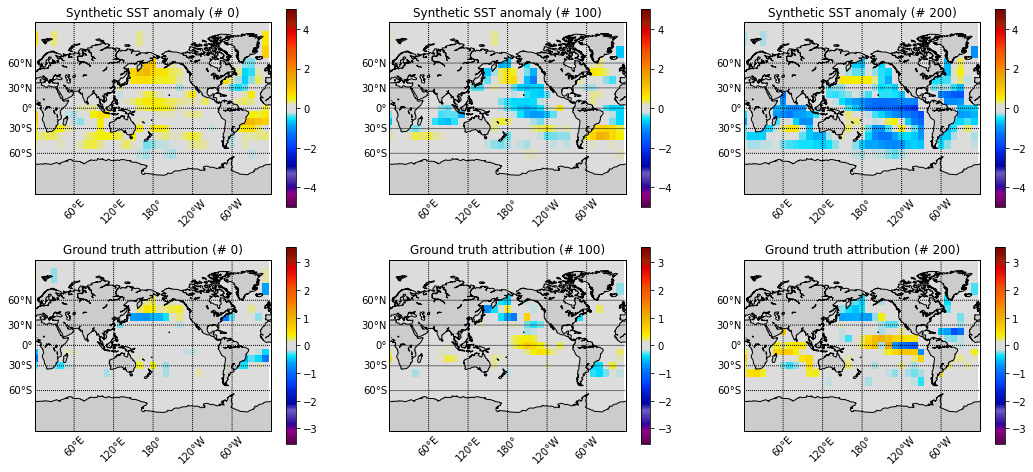

In [15]:
# Examples to plot
example_idxs = [0, 100, 200]
nExamples = len(example_idxs)

fig, axs = plt.subplots(2, 3, figsize=(18,8))
for i, e in enumerate(example_idxs):
    
    # Downsampled anomaly
    vmin = -5
    vmax = 5
    data = samples_grid[(e)]
    axs[0][i].title.set_text("Synthetic SST anomaly (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[0][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[0][i])
    
    # Attribution
    vmax = max(abs(attrMin), abs(attrMax))
    vmin = -vmax
    data = attr_grid[(e)]
    
    axs[1][i].title.set_text("Ground truth attribution (# {})".format(e))
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = axs[1][i])
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = axs[1][i])

# Approximate F with deep learning model

## Architecture

In [16]:
class MLP(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_sizes = [512, 256, 64, 32, 16]
        self.nHidden = len(self.hidden_sizes)
        # First layer
        self.input_layer = torch.nn.Linear(self.input_size, self.hidden_sizes[0])
        self.relu = torch.nn.ReLU()
        # Hidden layers
        self.hidden_layers = [
            torch.nn.Linear(self.hidden_sizes[i], self.hidden_sizes[i + 1]) \
            for i in range(self.nHidden - 1)]
        # Output layer
        self.output_layer = torch.nn.Linear(self.hidden_sizes[self.nHidden - 1], 1)
        
    def forward(self, x):
        layer1 = self.input_layer(x)
        relu = self.relu(layer1)
        for hidden_layer in self.hidden_layers:
            hl = hidden_layer(relu)
            relu = self.relu(hl)
        y = self.output_layer(relu)
        return y

## Setup data

In [17]:
nTrain = int(7e3)
x_train = torch.FloatTensor(X[0:nTrain])
y_train = torch.FloatTensor(y_values[0:nTrain])
input_len = x_train.shape[1]

x_test = torch.FloatTensor(X[nTrain:])
y_test = torch.FloatTensor(y_values[nTrain:])

## Initialize model

In [18]:
input_size = x_train.shape[1]
model = MLP(input_size)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

In [19]:
model.eval()
y_pred = model(x_test)
before_train = criterion(y_pred.squeeze(), y_test)
print('Test loss before training' , before_train.item())

Test loss before training 56.22560501098633


## Train model

In [20]:
model.train()
epoch = int(5e3)
for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute loss
    loss = criterion(y_pred.squeeze(), y_train)
    print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    # Backward pass
    loss.backward()
    optimizer.step()

Epoch 0: train loss: 57.259979248046875
Epoch 1: train loss: 57.11912536621094
Epoch 2: train loss: 56.98439025878906
Epoch 3: train loss: 56.85550308227539
Epoch 4: train loss: 56.73220443725586
Epoch 5: train loss: 56.61425018310547
Epoch 6: train loss: 56.50138473510742
Epoch 7: train loss: 56.39339828491211
Epoch 8: train loss: 56.290069580078125
Epoch 9: train loss: 56.191192626953125
Epoch 10: train loss: 56.096561431884766
Epoch 11: train loss: 56.006004333496094
Epoch 12: train loss: 55.91933059692383
Epoch 13: train loss: 55.83636474609375
Epoch 14: train loss: 55.7569465637207
Epoch 15: train loss: 55.68091583251953
Epoch 16: train loss: 55.608123779296875
Epoch 17: train loss: 55.53842544555664
Epoch 18: train loss: 55.4716682434082
Epoch 19: train loss: 55.40774917602539
Epoch 20: train loss: 55.346519470214844
Epoch 21: train loss: 55.287872314453125
Epoch 22: train loss: 55.23168182373047
Epoch 23: train loss: 55.1778450012207
Epoch 24: train loss: 55.12625503540039
Epoch

Epoch 204: train loss: 52.97267150878906
Epoch 205: train loss: 52.95854187011719
Epoch 206: train loss: 52.94424057006836
Epoch 207: train loss: 52.929771423339844
Epoch 208: train loss: 52.91512680053711
Epoch 209: train loss: 52.900299072265625
Epoch 210: train loss: 52.885276794433594
Epoch 211: train loss: 52.870052337646484
Epoch 212: train loss: 52.854637145996094
Epoch 213: train loss: 52.839027404785156
Epoch 214: train loss: 52.8232307434082
Epoch 215: train loss: 52.807212829589844
Epoch 216: train loss: 52.7910041809082
Epoch 217: train loss: 52.774593353271484
Epoch 218: train loss: 52.757991790771484
Epoch 219: train loss: 52.7412109375
Epoch 220: train loss: 52.724205017089844
Epoch 221: train loss: 52.707008361816406
Epoch 222: train loss: 52.68962478637695
Epoch 223: train loss: 52.67203140258789
Epoch 224: train loss: 52.654239654541016
Epoch 225: train loss: 52.63623046875
Epoch 226: train loss: 52.61800765991211
Epoch 227: train loss: 52.59959411621094
Epoch 228: tr

Epoch 405: train loss: 46.37663269042969
Epoch 406: train loss: 46.32382583618164
Epoch 407: train loss: 46.27081298828125
Epoch 408: train loss: 46.21760177612305
Epoch 409: train loss: 46.1641960144043
Epoch 410: train loss: 46.1105842590332
Epoch 411: train loss: 46.0567741394043
Epoch 412: train loss: 46.002769470214844
Epoch 413: train loss: 45.94858169555664
Epoch 414: train loss: 45.89418411254883
Epoch 415: train loss: 45.83958053588867
Epoch 416: train loss: 45.7847785949707
Epoch 417: train loss: 45.729759216308594
Epoch 418: train loss: 45.674530029296875
Epoch 419: train loss: 45.61909103393555
Epoch 420: train loss: 45.56342697143555
Epoch 421: train loss: 45.50756072998047
Epoch 422: train loss: 45.45150375366211
Epoch 423: train loss: 45.39521408081055
Epoch 424: train loss: 45.33873748779297
Epoch 425: train loss: 45.28204345703125
Epoch 426: train loss: 45.22512435913086
Epoch 427: train loss: 45.16800308227539
Epoch 428: train loss: 45.11066818237305
Epoch 429: train 

Epoch 609: train loss: 32.184391021728516
Epoch 610: train loss: 32.114044189453125
Epoch 611: train loss: 32.04381561279297
Epoch 612: train loss: 31.97374725341797
Epoch 613: train loss: 31.903812408447266
Epoch 614: train loss: 31.834012985229492
Epoch 615: train loss: 31.764352798461914
Epoch 616: train loss: 31.694826126098633
Epoch 617: train loss: 31.625455856323242
Epoch 618: train loss: 31.55624771118164
Epoch 619: train loss: 31.487201690673828
Epoch 620: train loss: 31.41830062866211
Epoch 621: train loss: 31.34953498840332
Epoch 622: train loss: 31.280914306640625
Epoch 623: train loss: 31.212448120117188
Epoch 624: train loss: 31.14410400390625
Epoch 625: train loss: 31.0759334564209
Epoch 626: train loss: 31.00794219970703
Epoch 627: train loss: 30.94010353088379
Epoch 628: train loss: 30.872392654418945
Epoch 629: train loss: 30.80485725402832
Epoch 630: train loss: 30.737472534179688
Epoch 631: train loss: 30.670259475708008
Epoch 632: train loss: 30.603214263916016
Epo

Epoch 809: train loss: 21.2725830078125
Epoch 810: train loss: 21.232669830322266
Epoch 811: train loss: 21.1928768157959
Epoch 812: train loss: 21.153207778930664
Epoch 813: train loss: 21.113683700561523
Epoch 814: train loss: 21.074298858642578
Epoch 815: train loss: 21.035036087036133
Epoch 816: train loss: 20.995866775512695
Epoch 817: train loss: 20.956830978393555
Epoch 818: train loss: 20.91791534423828
Epoch 819: train loss: 20.87912940979004
Epoch 820: train loss: 20.840431213378906
Epoch 821: train loss: 20.801830291748047
Epoch 822: train loss: 20.76331901550293
Epoch 823: train loss: 20.724916458129883
Epoch 824: train loss: 20.686603546142578
Epoch 825: train loss: 20.648414611816406
Epoch 826: train loss: 20.610342025756836
Epoch 827: train loss: 20.572383880615234
Epoch 828: train loss: 20.534528732299805
Epoch 829: train loss: 20.49677848815918
Epoch 830: train loss: 20.4591121673584
Epoch 831: train loss: 20.42152976989746
Epoch 832: train loss: 20.384017944335938
Epo

Epoch 1007: train loss: 15.319801330566406
Epoch 1008: train loss: 15.298163414001465
Epoch 1009: train loss: 15.27658748626709
Epoch 1010: train loss: 15.255072593688965
Epoch 1011: train loss: 15.233633041381836
Epoch 1012: train loss: 15.21225643157959
Epoch 1013: train loss: 15.190946578979492
Epoch 1014: train loss: 15.169706344604492
Epoch 1015: train loss: 15.148527145385742
Epoch 1016: train loss: 15.127419471740723
Epoch 1017: train loss: 15.106364250183105
Epoch 1018: train loss: 15.085367202758789
Epoch 1019: train loss: 15.064435958862305
Epoch 1020: train loss: 15.043580055236816
Epoch 1021: train loss: 15.022772789001465
Epoch 1022: train loss: 15.002039909362793
Epoch 1023: train loss: 14.981368064880371
Epoch 1024: train loss: 14.960756301879883
Epoch 1025: train loss: 14.94022274017334
Epoch 1026: train loss: 14.91976547241211
Epoch 1027: train loss: 14.899360656738281
Epoch 1028: train loss: 14.879013061523438
Epoch 1029: train loss: 14.858738899230957
Epoch 1030: tra

Epoch 1200: train loss: 12.164690017700195
Epoch 1201: train loss: 12.152505874633789
Epoch 1202: train loss: 12.14035415649414
Epoch 1203: train loss: 12.128232955932617
Epoch 1204: train loss: 12.116153717041016
Epoch 1205: train loss: 12.104111671447754
Epoch 1206: train loss: 12.092103004455566
Epoch 1207: train loss: 12.080123901367188
Epoch 1208: train loss: 12.068167686462402
Epoch 1209: train loss: 12.056245803833008
Epoch 1210: train loss: 12.044352531433105
Epoch 1211: train loss: 12.032490730285645
Epoch 1212: train loss: 12.020660400390625
Epoch 1213: train loss: 12.008854866027832
Epoch 1214: train loss: 11.997077941894531
Epoch 1215: train loss: 11.985331535339355
Epoch 1216: train loss: 11.973617553710938
Epoch 1217: train loss: 11.961934089660645
Epoch 1218: train loss: 11.950291633605957
Epoch 1219: train loss: 11.938671112060547
Epoch 1220: train loss: 11.927074432373047
Epoch 1221: train loss: 11.915495872497559
Epoch 1222: train loss: 11.903947830200195
Epoch 1223: 

Epoch 1393: train loss: 10.288795471191406
Epoch 1394: train loss: 10.281132698059082
Epoch 1395: train loss: 10.273493766784668
Epoch 1396: train loss: 10.265872955322266
Epoch 1397: train loss: 10.258270263671875
Epoch 1398: train loss: 10.250679969787598
Epoch 1399: train loss: 10.2431058883667
Epoch 1400: train loss: 10.235552787780762
Epoch 1401: train loss: 10.228015899658203
Epoch 1402: train loss: 10.220494270324707
Epoch 1403: train loss: 10.212986946105957
Epoch 1404: train loss: 10.205497741699219
Epoch 1405: train loss: 10.198028564453125
Epoch 1406: train loss: 10.19057559967041
Epoch 1407: train loss: 10.183141708374023
Epoch 1408: train loss: 10.175722122192383
Epoch 1409: train loss: 10.168309211730957
Epoch 1410: train loss: 10.160921096801758
Epoch 1411: train loss: 10.153547286987305
Epoch 1412: train loss: 10.146187782287598
Epoch 1413: train loss: 10.138849258422852
Epoch 1414: train loss: 10.131522178649902
Epoch 1415: train loss: 10.124212265014648
Epoch 1416: tr

Epoch 1592: train loss: 9.063687324523926
Epoch 1593: train loss: 9.05870532989502
Epoch 1594: train loss: 9.053738594055176
Epoch 1595: train loss: 9.048785209655762
Epoch 1596: train loss: 9.04384708404541
Epoch 1597: train loss: 9.038918495178223
Epoch 1598: train loss: 9.034004211425781
Epoch 1599: train loss: 9.029094696044922
Epoch 1600: train loss: 9.024195671081543
Epoch 1601: train loss: 9.019304275512695
Epoch 1602: train loss: 9.014426231384277
Epoch 1603: train loss: 9.009557723999023
Epoch 1604: train loss: 9.0046968460083
Epoch 1605: train loss: 8.999846458435059
Epoch 1606: train loss: 8.995007514953613
Epoch 1607: train loss: 8.990180015563965
Epoch 1608: train loss: 8.985360145568848
Epoch 1609: train loss: 8.980552673339844
Epoch 1610: train loss: 8.975754737854004
Epoch 1611: train loss: 8.970969200134277
Epoch 1612: train loss: 8.966188430786133
Epoch 1613: train loss: 8.961417198181152
Epoch 1614: train loss: 8.956655502319336
Epoch 1615: train loss: 8.951904296875

Epoch 1790: train loss: 8.2524995803833
Epoch 1791: train loss: 8.249080657958984
Epoch 1792: train loss: 8.245670318603516
Epoch 1793: train loss: 8.24227237701416
Epoch 1794: train loss: 8.23887825012207
Epoch 1795: train loss: 8.235485076904297
Epoch 1796: train loss: 8.232094764709473
Epoch 1797: train loss: 8.228710174560547
Epoch 1798: train loss: 8.225332260131836
Epoch 1799: train loss: 8.221960067749023
Epoch 1800: train loss: 8.218596458435059
Epoch 1801: train loss: 8.215229988098145
Epoch 1802: train loss: 8.211857795715332
Epoch 1803: train loss: 8.208486557006836
Epoch 1804: train loss: 8.205116271972656
Epoch 1805: train loss: 8.201741218566895
Epoch 1806: train loss: 8.198348999023438
Epoch 1807: train loss: 8.194963455200195
Epoch 1808: train loss: 8.191584587097168
Epoch 1809: train loss: 8.188209533691406
Epoch 1810: train loss: 8.184835433959961
Epoch 1811: train loss: 8.181464195251465
Epoch 1812: train loss: 8.178093910217285
Epoch 1813: train loss: 8.174720764160

Epoch 1989: train loss: 7.658243656158447
Epoch 1990: train loss: 7.655656814575195
Epoch 1991: train loss: 7.653073310852051
Epoch 1992: train loss: 7.650496006011963
Epoch 1993: train loss: 7.647923946380615
Epoch 1994: train loss: 7.64535665512085
Epoch 1995: train loss: 7.642794609069824
Epoch 1996: train loss: 7.640237808227539
Epoch 1997: train loss: 7.637685298919678
Epoch 1998: train loss: 7.6351318359375
Epoch 1999: train loss: 7.632584095001221
Epoch 2000: train loss: 7.6300458908081055
Epoch 2001: train loss: 7.627512454986572
Epoch 2002: train loss: 7.624983310699463
Epoch 2003: train loss: 7.622456073760986
Epoch 2004: train loss: 7.619931697845459
Epoch 2005: train loss: 7.6174116134643555
Epoch 2006: train loss: 7.61489725112915
Epoch 2007: train loss: 7.612389087677002
Epoch 2008: train loss: 7.609894752502441
Epoch 2009: train loss: 7.6074113845825195
Epoch 2010: train loss: 7.6049346923828125
Epoch 2011: train loss: 7.602463722229004
Epoch 2012: train loss: 7.59999942

Epoch 2185: train loss: 7.209289073944092
Epoch 2186: train loss: 7.207303524017334
Epoch 2187: train loss: 7.205320358276367
Epoch 2188: train loss: 7.203341007232666
Epoch 2189: train loss: 7.2013678550720215
Epoch 2190: train loss: 7.199399471282959
Epoch 2191: train loss: 7.197430610656738
Epoch 2192: train loss: 7.195468902587891
Epoch 2193: train loss: 7.193505764007568
Epoch 2194: train loss: 7.19154167175293
Epoch 2195: train loss: 7.189583778381348
Epoch 2196: train loss: 7.187628746032715
Epoch 2197: train loss: 7.1856770515441895
Epoch 2198: train loss: 7.1837286949157715
Epoch 2199: train loss: 7.181787014007568
Epoch 2200: train loss: 7.179849147796631
Epoch 2201: train loss: 7.177916526794434
Epoch 2202: train loss: 7.175983905792236
Epoch 2203: train loss: 7.174046516418457
Epoch 2204: train loss: 7.172113418579102
Epoch 2205: train loss: 7.170182704925537
Epoch 2206: train loss: 7.168252468109131
Epoch 2207: train loss: 7.166324138641357
Epoch 2208: train loss: 7.164400

Epoch 2384: train loss: 6.8550333976745605
Epoch 2385: train loss: 6.853439807891846
Epoch 2386: train loss: 6.851846218109131
Epoch 2387: train loss: 6.850250720977783
Epoch 2388: train loss: 6.848659515380859
Epoch 2389: train loss: 6.847070217132568
Epoch 2390: train loss: 6.845480442047119
Epoch 2391: train loss: 6.8438920974731445
Epoch 2392: train loss: 6.842308044433594
Epoch 2393: train loss: 6.840724468231201
Epoch 2394: train loss: 6.839142799377441
Epoch 2395: train loss: 6.837562084197998
Epoch 2396: train loss: 6.8359880447387695
Epoch 2397: train loss: 6.834414958953857
Epoch 2398: train loss: 6.832845211029053
Epoch 2399: train loss: 6.831277370452881
Epoch 2400: train loss: 6.829713821411133
Epoch 2401: train loss: 6.828149318695068
Epoch 2402: train loss: 6.826586723327637
Epoch 2403: train loss: 6.825026988983154
Epoch 2404: train loss: 6.82346773147583
Epoch 2405: train loss: 6.821910858154297
Epoch 2406: train loss: 6.820354461669922
Epoch 2407: train loss: 6.818800

Epoch 2583: train loss: 6.572027683258057
Epoch 2584: train loss: 6.570774078369141
Epoch 2585: train loss: 6.569522380828857
Epoch 2586: train loss: 6.568272113800049
Epoch 2587: train loss: 6.567019462585449
Epoch 2588: train loss: 6.565771102905273
Epoch 2589: train loss: 6.5645222663879395
Epoch 2590: train loss: 6.563275337219238
Epoch 2591: train loss: 6.56203031539917
Epoch 2592: train loss: 6.56078577041626
Epoch 2593: train loss: 6.55954647064209
Epoch 2594: train loss: 6.558304309844971
Epoch 2595: train loss: 6.557066440582275
Epoch 2596: train loss: 6.5558271408081055
Epoch 2597: train loss: 6.554591178894043
Epoch 2598: train loss: 6.553356170654297
Epoch 2599: train loss: 6.552123546600342
Epoch 2600: train loss: 6.550891399383545
Epoch 2601: train loss: 6.549661636352539
Epoch 2602: train loss: 6.548431396484375
Epoch 2603: train loss: 6.5472002029418945
Epoch 2604: train loss: 6.545970916748047
Epoch 2605: train loss: 6.544738292694092
Epoch 2606: train loss: 6.54351043

Epoch 2781: train loss: 6.346695899963379
Epoch 2782: train loss: 6.345666408538818
Epoch 2783: train loss: 6.344641208648682
Epoch 2784: train loss: 6.343616008758545
Epoch 2785: train loss: 6.342592716217041
Epoch 2786: train loss: 6.341567039489746
Epoch 2787: train loss: 6.3405442237854
Epoch 2788: train loss: 6.339519023895264
Epoch 2789: train loss: 6.338497161865234
Epoch 2790: train loss: 6.337471961975098
Epoch 2791: train loss: 6.336451053619385
Epoch 2792: train loss: 6.335428714752197
Epoch 2793: train loss: 6.334409236907959
Epoch 2794: train loss: 6.3333916664123535
Epoch 2795: train loss: 6.332374095916748
Epoch 2796: train loss: 6.331358432769775
Epoch 2797: train loss: 6.330343246459961
Epoch 2798: train loss: 6.329329967498779
Epoch 2799: train loss: 6.328313827514648
Epoch 2800: train loss: 6.32729959487915
Epoch 2801: train loss: 6.326287269592285
Epoch 2802: train loss: 6.325275897979736
Epoch 2803: train loss: 6.3242645263671875
Epoch 2804: train loss: 6.323252677

Epoch 2978: train loss: 6.15831995010376
Epoch 2979: train loss: 6.157419204711914
Epoch 2980: train loss: 6.156520843505859
Epoch 2981: train loss: 6.155622959136963
Epoch 2982: train loss: 6.154726505279541
Epoch 2983: train loss: 6.153828144073486
Epoch 2984: train loss: 6.152933120727539
Epoch 2985: train loss: 6.152037620544434
Epoch 2986: train loss: 6.151142120361328
Epoch 2987: train loss: 6.150249004364014
Epoch 2988: train loss: 6.149352550506592
Epoch 2989: train loss: 6.1484575271606445
Epoch 2990: train loss: 6.147563457489014
Epoch 2991: train loss: 6.146669864654541
Epoch 2992: train loss: 6.145777702331543
Epoch 2993: train loss: 6.144885063171387
Epoch 2994: train loss: 6.1439971923828125
Epoch 2995: train loss: 6.143105506896973
Epoch 2996: train loss: 6.142218112945557
Epoch 2997: train loss: 6.14132833480835
Epoch 2998: train loss: 6.140444278717041
Epoch 2999: train loss: 6.139557838439941
Epoch 3000: train loss: 6.138672828674316
Epoch 3001: train loss: 6.13778924

Epoch 3175: train loss: 5.991958141326904
Epoch 3176: train loss: 5.991166114807129
Epoch 3177: train loss: 5.990372657775879
Epoch 3178: train loss: 5.98958158493042
Epoch 3179: train loss: 5.988790512084961
Epoch 3180: train loss: 5.988002777099609
Epoch 3181: train loss: 5.987213134765625
Epoch 3182: train loss: 5.986422538757324
Epoch 3183: train loss: 5.9856343269348145
Epoch 3184: train loss: 5.9848456382751465
Epoch 3185: train loss: 5.984055995941162
Epoch 3186: train loss: 5.983264923095703
Epoch 3187: train loss: 5.982478618621826
Epoch 3188: train loss: 5.981688499450684
Epoch 3189: train loss: 5.980900764465332
Epoch 3190: train loss: 5.980113983154297
Epoch 3191: train loss: 5.979327201843262
Epoch 3192: train loss: 5.978542804718018
Epoch 3193: train loss: 5.977754592895508
Epoch 3194: train loss: 5.976971626281738
Epoch 3195: train loss: 5.976184368133545
Epoch 3196: train loss: 5.975398540496826
Epoch 3197: train loss: 5.974615573883057
Epoch 3198: train loss: 5.9738292

Epoch 3370: train loss: 5.846226215362549
Epoch 3371: train loss: 5.845524787902832
Epoch 3372: train loss: 5.844818592071533
Epoch 3373: train loss: 5.844119548797607
Epoch 3374: train loss: 5.843415260314941
Epoch 3375: train loss: 5.842710971832275
Epoch 3376: train loss: 5.842007160186768
Epoch 3377: train loss: 5.841307640075684
Epoch 3378: train loss: 5.84060525894165
Epoch 3379: train loss: 5.839903354644775
Epoch 3380: train loss: 5.839203357696533
Epoch 3381: train loss: 5.838505744934082
Epoch 3382: train loss: 5.837802410125732
Epoch 3383: train loss: 5.837103843688965
Epoch 3384: train loss: 5.8364033699035645
Epoch 3385: train loss: 5.835704803466797
Epoch 3386: train loss: 5.8350043296813965
Epoch 3387: train loss: 5.83430814743042
Epoch 3388: train loss: 5.833610534667969
Epoch 3389: train loss: 5.8329081535339355
Epoch 3390: train loss: 5.832211017608643
Epoch 3391: train loss: 5.83151388168335
Epoch 3392: train loss: 5.83081579208374
Epoch 3393: train loss: 5.830118656

Epoch 3569: train loss: 5.71142053604126
Epoch 3570: train loss: 5.710763454437256
Epoch 3571: train loss: 5.710110664367676
Epoch 3572: train loss: 5.709453105926514
Epoch 3573: train loss: 5.70880126953125
Epoch 3574: train loss: 5.7081475257873535
Epoch 3575: train loss: 5.707492828369141
Epoch 3576: train loss: 5.706838607788086
Epoch 3577: train loss: 5.706187725067139
Epoch 3578: train loss: 5.705533981323242
Epoch 3579: train loss: 5.704878807067871
Epoch 3580: train loss: 5.704226493835449
Epoch 3581: train loss: 5.7035746574401855
Epoch 3582: train loss: 5.702919006347656
Epoch 3583: train loss: 5.70226526260376
Epoch 3584: train loss: 5.701615333557129
Epoch 3585: train loss: 5.7009596824646
Epoch 3586: train loss: 5.700306415557861
Epoch 3587: train loss: 5.6996564865112305
Epoch 3588: train loss: 5.699004650115967
Epoch 3589: train loss: 5.698347091674805
Epoch 3590: train loss: 5.697694301605225
Epoch 3591: train loss: 5.697041988372803
Epoch 3592: train loss: 5.6963887214

Epoch 3765: train loss: 5.588387966156006
Epoch 3766: train loss: 5.58778715133667
Epoch 3767: train loss: 5.587183475494385
Epoch 3768: train loss: 5.586587429046631
Epoch 3769: train loss: 5.585987567901611
Epoch 3770: train loss: 5.585384845733643
Epoch 3771: train loss: 5.584784507751465
Epoch 3772: train loss: 5.584184169769287
Epoch 3773: train loss: 5.583587646484375
Epoch 3774: train loss: 5.582988262176514
Epoch 3775: train loss: 5.582386493682861
Epoch 3776: train loss: 5.581786155700684
Epoch 3777: train loss: 5.5811896324157715
Epoch 3778: train loss: 5.580586910247803
Epoch 3779: train loss: 5.579988479614258
Epoch 3780: train loss: 5.579391002655029
Epoch 3781: train loss: 5.578794479370117
Epoch 3782: train loss: 5.578193664550781
Epoch 3783: train loss: 5.577593803405762
Epoch 3784: train loss: 5.576997756958008
Epoch 3785: train loss: 5.5763983726501465
Epoch 3786: train loss: 5.575804710388184
Epoch 3787: train loss: 5.575206279754639
Epoch 3788: train loss: 5.5746116

Epoch 3963: train loss: 5.4744977951049805
Epoch 3964: train loss: 5.4739460945129395
Epoch 3965: train loss: 5.473390579223633
Epoch 3966: train loss: 5.472838878631592
Epoch 3967: train loss: 5.472285747528076
Epoch 3968: train loss: 5.471734523773193
Epoch 3969: train loss: 5.471182346343994
Epoch 3970: train loss: 5.470627784729004
Epoch 3971: train loss: 5.470080852508545
Epoch 3972: train loss: 5.469526767730713
Epoch 3973: train loss: 5.468973636627197
Epoch 3974: train loss: 5.46842622756958
Epoch 3975: train loss: 5.467874050140381
Epoch 3976: train loss: 5.467324733734131
Epoch 3977: train loss: 5.466777801513672
Epoch 3978: train loss: 5.466225624084473
Epoch 3979: train loss: 5.465676307678223
Epoch 3980: train loss: 5.4651265144348145
Epoch 3981: train loss: 5.464580535888672
Epoch 3982: train loss: 5.464034557342529
Epoch 3983: train loss: 5.463484764099121
Epoch 3984: train loss: 5.462935924530029
Epoch 3985: train loss: 5.462389945983887
Epoch 3986: train loss: 5.461842

Epoch 4159: train loss: 5.369448661804199
Epoch 4160: train loss: 5.368927001953125
Epoch 4161: train loss: 5.368409156799316
Epoch 4162: train loss: 5.367888927459717
Epoch 4163: train loss: 5.367368698120117
Epoch 4164: train loss: 5.366851329803467
Epoch 4165: train loss: 5.3663330078125
Epoch 4166: train loss: 5.365811824798584
Epoch 4167: train loss: 5.365296840667725
Epoch 4168: train loss: 5.364781379699707
Epoch 4169: train loss: 5.364264011383057
Epoch 4170: train loss: 5.3637495040893555
Epoch 4171: train loss: 5.363231658935547
Epoch 4172: train loss: 5.362720966339111
Epoch 4173: train loss: 5.362203598022461
Epoch 4174: train loss: 5.3616862297058105
Epoch 4175: train loss: 5.361174583435059
Epoch 4176: train loss: 5.360658645629883
Epoch 4177: train loss: 5.360144138336182
Epoch 4178: train loss: 5.3596296310424805
Epoch 4179: train loss: 5.359118461608887
Epoch 4180: train loss: 5.358608245849609
Epoch 4181: train loss: 5.358097076416016
Epoch 4182: train loss: 5.3575844

Epoch 4356: train loss: 5.272604942321777
Epoch 4357: train loss: 5.272137641906738
Epoch 4358: train loss: 5.271670818328857
Epoch 4359: train loss: 5.271197319030762
Epoch 4360: train loss: 5.270727634429932
Epoch 4361: train loss: 5.270263195037842
Epoch 4362: train loss: 5.269794464111328
Epoch 4363: train loss: 5.269321441650391
Epoch 4364: train loss: 5.268853187561035
Epoch 4365: train loss: 5.268388271331787
Epoch 4366: train loss: 5.267920970916748
Epoch 4367: train loss: 5.267457008361816
Epoch 4368: train loss: 5.266985893249512
Epoch 4369: train loss: 5.26651668548584
Epoch 4370: train loss: 5.266050815582275
Epoch 4371: train loss: 5.265589237213135
Epoch 4372: train loss: 5.265120983123779
Epoch 4373: train loss: 5.264650821685791
Epoch 4374: train loss: 5.264187335968018
Epoch 4375: train loss: 5.263718128204346
Epoch 4376: train loss: 5.263254642486572
Epoch 4377: train loss: 5.262789726257324
Epoch 4378: train loss: 5.262319087982178
Epoch 4379: train loss: 5.261852741

Epoch 4553: train loss: 5.184120178222656
Epoch 4554: train loss: 5.183691501617432
Epoch 4555: train loss: 5.183256149291992
Epoch 4556: train loss: 5.182818412780762
Epoch 4557: train loss: 5.1823835372924805
Epoch 4558: train loss: 5.1819586753845215
Epoch 4559: train loss: 5.181519031524658
Epoch 4560: train loss: 5.181084156036377
Epoch 4561: train loss: 5.180653095245361
Epoch 4562: train loss: 5.18021821975708
Epoch 4563: train loss: 5.17979097366333
Epoch 4564: train loss: 5.179353713989258
Epoch 4565: train loss: 5.178918361663818
Epoch 4566: train loss: 5.178492069244385
Epoch 4567: train loss: 5.17805814743042
Epoch 4568: train loss: 5.177623748779297
Epoch 4569: train loss: 5.177189350128174
Epoch 4570: train loss: 5.17676305770874
Epoch 4571: train loss: 5.176324367523193
Epoch 4572: train loss: 5.175893306732178
Epoch 4573: train loss: 5.175462245941162
Epoch 4574: train loss: 5.175034046173096
Epoch 4575: train loss: 5.174602031707764
Epoch 4576: train loss: 5.1741662025

Epoch 4748: train loss: 5.101720333099365
Epoch 4749: train loss: 5.101313591003418
Epoch 4750: train loss: 5.100897312164307
Epoch 4751: train loss: 5.100483417510986
Epoch 4752: train loss: 5.100074768066406
Epoch 4753: train loss: 5.0996623039245605
Epoch 4754: train loss: 5.099247932434082
Epoch 4755: train loss: 5.098836421966553
Epoch 4756: train loss: 5.098424434661865
Epoch 4757: train loss: 5.098016262054443
Epoch 4758: train loss: 5.097602844238281
Epoch 4759: train loss: 5.097187519073486
Epoch 4760: train loss: 5.096782207489014
Epoch 4761: train loss: 5.09636926651001
Epoch 4762: train loss: 5.095956802368164
Epoch 4763: train loss: 5.095542907714844
Epoch 4764: train loss: 5.095137119293213
Epoch 4765: train loss: 5.094723701477051
Epoch 4766: train loss: 5.094313144683838
Epoch 4767: train loss: 5.093903064727783
Epoch 4768: train loss: 5.093494415283203
Epoch 4769: train loss: 5.093081951141357
Epoch 4770: train loss: 5.092672824859619
Epoch 4771: train loss: 5.09226799

Epoch 4946: train loss: 5.022646427154541
Epoch 4947: train loss: 5.0222554206848145
Epoch 4948: train loss: 5.0218658447265625
Epoch 4949: train loss: 5.021476745605469
Epoch 4950: train loss: 5.021084785461426
Epoch 4951: train loss: 5.020691871643066
Epoch 4952: train loss: 5.020304203033447
Epoch 4953: train loss: 5.019913673400879
Epoch 4954: train loss: 5.019522190093994
Epoch 4955: train loss: 5.019132614135742
Epoch 4956: train loss: 5.018746852874756
Epoch 4957: train loss: 5.018351078033447
Epoch 4958: train loss: 5.017961025238037
Epoch 4959: train loss: 5.017574310302734
Epoch 4960: train loss: 5.017181873321533
Epoch 4961: train loss: 5.016794681549072
Epoch 4962: train loss: 5.016404151916504
Epoch 4963: train loss: 5.0160136222839355
Epoch 4964: train loss: 5.015625
Epoch 4965: train loss: 5.015238285064697
Epoch 4966: train loss: 5.014847278594971
Epoch 4967: train loss: 5.014457702636719
Epoch 4968: train loss: 5.014072895050049
Epoch 4969: train loss: 5.01368093490600

## Calculate metrics

In [21]:
y_pred_train = y_pred.detach().numpy()
r2_train = r2_score(y_true=y_train, y_pred=y_pred_train)
print("Training R2 score = {}".format(r2_train))

model.eval()
y_pred_test = model(x_test).detach().numpy()
r2_test = r2_score(y_true=y_test, y_pred=y_pred_test)
print("Testing R2 score = {}".format(r2_test))

Training R2 score = 0.9074960897592096
Testing R2 score = 0.8924802653908387


# XAI

In [22]:
example_idxs = [0, 100, 200]
x_xai = x_train[example_idxs]
y_pred_xai = torch.FloatTensor(y_pred_train[example_idxs].squeeze())
if len(x_xai.shape) == 1:
    x_xai = x_xai.unsqueeze(0)
nSamples = x_xai.shape[0]
print("XAI samples shape: ", x.shape)
print("      preds shape: ", y_pred_xai.shape)

XAI samples shape:  (18, 36)
      preds shape:  torch.Size([3])


### Gradient (a.k.a. saliency map)

In [23]:
sm = Saliency(model)
attr_saliencyMap = sm.attribute(x_xai, abs = False)
attr_saliencyMap_grid = attr_saliencyMap.reshape(nSamples, sst_shape[1], sst_shape[2])

/home/ekrell/anaconda3/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


### Smooth Gradient

In [24]:
sg = NoiseTunnel(sm)
attr_smoothGrad = sg.attribute(x_xai, nt_type="smoothgrad", abs = False)
attr_smoothGrad_grid = attr_smoothGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

### Integrated gradients

In [25]:
ig = IntegratedGradients(model)
attr_inputTimeGrad = ig.attribute(x_xai)#, baseline, target=0, return_convergence_delta=True)
attr_inputTimeGrad_grid = attr_inputTimeGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

### Input X gradient

In [26]:
ixg = InputXGradient(model)
attr_inputXGrad = ixg.attribute(x_xai).detach().numpy()
attr_inputXGrad_grid = attr_inputXGrad.reshape(nSamples, sst_shape[1], sst_shape[2])

### LRP_z

In [27]:
lrpz = LRP(model)
attr_lrpz = lrpz.attribute(x_xai).detach().numpy()
attr_lrpz_grid = attr_lrpz.reshape(nSamples, sst_shape[1], sst_shape[2])

### LIME

In [28]:
lime = Lime(model)
attr_lime = lime.attribute(x_xai).detach().numpy()
attr_lime_grid = attr_lime.reshape(nSamples, sst_shape[1], sst_shape[2])

/home/ekrell/anaconda3/lib/python3.8/site-packages/captum/attr/_core/lime.py:1110: UserWarning: You are providing multiple inputs for Lime / Kernel SHAP attributions. This trains a separate interpretable model for each example, which can be time consuming. It is recommended to compute attributions for one example at a time.
  warnings.warn(


### KernelSHAP

In [ ]:
kshap = KernelShap(model)
attr_kshap = kshap.attribute(x_xai).detach().numpy()
attr_kshap_grid = attr_kshap.reshape(nSamples, sst_shape[1], sst_shape[2])

## Plot XAI attributions

In [ ]:
nExamples = len(example_idxs)
nPlot = min(nSamples, 3)   # Print at most 3

def plotAttrib(dataset, index, title, ax):
    # Colorbar limits
    vmax = max(abs(np.nanmax(dataset)), abs(np.nanmin(dataset)))
    vmin = -vmax
    # Selected sample
    data = dataset[(index)]
    # Plot title
    ax.title.set_text(title)
    # Geospatial basemap
    m = Basemap(projection='mill', lat_ts=10, \
            llcrnrlon=np.nanmin(lon), urcrnrlon=np.nanmax(lon), \
            llcrnrlat=lat.min(), urcrnrlat=lat.max(), \
            resolution='c', ax = ax)
    lat_ = lat[::10]
    lon_ = lon[::10]
    Lon, Lat = meshgrid(lon_,lat_)
    x, y = m(Lon,Lat)
    # Plot data
    cs = m.pcolormesh(x,y,data,shading='auto', vmin=vmin, vmax=vmax, \
      cmap=cmap)
    # Plot geospatial chart elements
    m.drawcoastlines();
    m.fillcontinents();
    m.drawmapboundary();
    m.drawparallels(np.arange(-90.,120.,30.), \
      labels=[1,0,0,0]);
    m.drawmeridians(np.arange(-180.,180.,60.), \
      labels=[0,0,0,1], rotation=45);
    colorbar(cs, ax = ax)    
    
fig, axs = plt.subplots(8, nPlot, figsize=(32,20))
for i, e in enumerate(example_idxs):
    plotAttrib(attr_grid, i, "Ground truth attribution (# {})".format(e), ax=axs[0][i])
    plotAttrib(attr_saliencyMap_grid, i, "Gradient (# {})".format(e), ax=axs[1][i])
    plotAttrib(attr_smoothGrad_grid, i, "Smooth Gradient (# {})".format(e), ax=axs[2][i])
    plotAttrib(attr_inputXGrad_grid, i, "Input X Gradient (# {})".format(e), ax=axs[3][i])
    plotAttrib(attr_inputTimeGrad_grid, i, "Integrated Gradients (# {})".format(e), ax=axs[4][i])
    plotAttrib(attr_lrpz_grid, i, "LRP_z (# {})".format(e), ax=axs[5][i])
    plotAttrib(attr_lime_grid, i, "LIME (# {})".format(e), ax=axs[6][i])
    plotAttrib(attr_kshap_grid, i, "KernelShap (# {})".format(e), ax=axs[6][i])